BCI Sample Size Determination (SSD)

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import special
import matplotlib.pyplot as plt
import json
import time

In [2]:
# sample size
# n_subjects = [4, 8, 12, 16, 24] # number of subjects
# n_trials = [20, 36, 64] # number of trials
# n_subjects = [4, 5, 6, 7, 8, 9, 10] # number of subjects
n_subjects = [5, 10, 15, 20] # number of subjects
n_trials = [140] # number of trials

M = 3 # iterations

# MCMC
n_samples = 5000
n_chains = 3
n_tune = 500

# initialize results dict
timestamp = time.strftime("%Y%m%d%H%M")
params = {'n_trials': n_trials, 'n_subjects': n_subjects, 'M': M,
          'n_samples': n_samples, 'n_chains': n_chains, 'n_tune': n_tune
          }
results = np.zeros((len(n_subjects), len(n_trials), M))

In [3]:
for s in range(len(n_subjects)):
    for t in range(len(n_trials)):
        for m in range(M):
            # print iteration info
            print("M: "+str(m)+"\t Ns: "+str(s)+"\t T: "+str(t))
            
            # draw parameters (theta hat) from sampling prior
            mu_phi = np.random.uniform(0.55, 0.95)
            mu_alpha = special.logit(mu_phi)
            sigma_alpha = np.random.uniform(0.2, 1.2)
            
            alpha = np.random.normal(mu_alpha, sigma_alpha, n_subjects[s])
            phi = special.expit(alpha)
            
            # draw dataset D^(n) from sampling distribution
            y = np.random.binomial(n_trials[t], phi) # vector of size Ns
            
            # compute delta(D^(n)) using Baye's rule (via MCMC)
            with pm.Model() as model:
                # priors for group level parameters - a single value for mean and std
                group_level_mean_logit = pm.Normal('μ_α', mu=0, sd=2**0.5)
                group_level_std_logit = pm.Uniform('σ_α', lower=0., upper=10.)
                
                group_level_mean_prob = pm.Deterministic('μ_φ', pm.math.invlogit(group_level_mean_logit))
                
                # subject level parameters - vector of size Ns
                subject_level_accuracy_logit = pm.Normal('α', mu=group_level_mean_logit, sd=group_level_std_logit, shape=n_subjects[s])
                subject_level_accuracy_prob = pm.Deterministic('φ', pm.math.invlogit(subject_level_accuracy_logit))
                
                # likelihood (sampling distributions) of observations
                y_obs = []
                for i in range(n_subjects[s]):
                    y_obs_i = pm.Binomial('y_obs_'+str(i), n=n_trials[t], p=subject_level_accuracy_prob[i], observed=y[i])
                    y_obs.append(y_obs_i)
                
                # draw posterior samples
                trace = pm.sample(n_samples, chains=n_chains, tune=n_tune, discard_tuned_samples=True)
            
            # posterior analysis
            trace_np = pd.DataFrame(trace['α']).to_numpy() # 15000 x Ns array of subject-level accuracies
            
            # take mean across all Ns subjects --> vector of 15000
            group_level_mean_logit_hat = np.mean(trace_np, axis=1)
            
            # compute 95% CI
            delta = np.percentile(group_level_mean_logit_hat, 97.5) - np.percentile(group_level_mean_logit_hat, 2.5)
            results[s][t][m] = delta


M: 0	 Ns: 0	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 5 divergences: 100%|██████████| 16500/16500 [00:13<00:00, 1249.87draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.887959895423046, but should be close to 0.8. Try to increase the number of tuning steps.


M: 1	 Ns: 0	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:12<00:00, 1334.31draws/s]


M: 2	 Ns: 0	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 1 divergences: 100%|██████████| 16500/16500 [00:13<00:00, 1237.77draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


M: 0	 Ns: 1	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:14<00:00, 1100.84draws/s]


M: 1	 Ns: 1	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:14<00:00, 1100.36draws/s]


M: 2	 Ns: 1	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:14<00:00, 1132.28draws/s]


M: 0	 Ns: 2	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:17<00:00, 954.11draws/s] 


M: 1	 Ns: 2	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:18<00:00, 906.54draws/s] 


M: 2	 Ns: 2	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:18<00:00, 889.81draws/s] 


M: 0	 Ns: 3	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:19<00:00, 847.08draws/s] 


M: 1	 Ns: 3	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:19<00:00, 859.43draws/s] 


M: 2	 Ns: 3	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:19<00:00, 849.63draws/s] 


In [4]:
# Save params as json file
np.save(timestamp+'_alc_results', results)
with open(timestamp+'_alc_params.txt', 'w') as outfile:
    json.dump(params, outfile)

In [5]:
results

array([[[0.37262299, 0.34760753, 0.92876613]],

       [[0.29841407, 0.21518473, 0.33199058]],

       [[0.28916183, 0.18867357, 0.18010359]],

       [[0.15856596, 0.25062419, 0.15489757]]])

In [14]:
np.mean(results[3]) / 2

0.09401461987204367

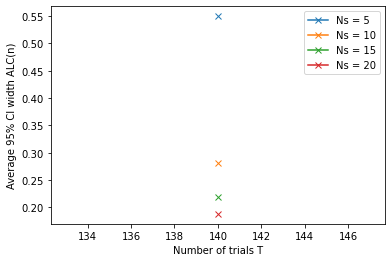

In [7]:
# Save ALC plot
plt.xlabel('Number of trials T');
plt.ylabel('Average 95% CI width ALC(n)');

for s in range(len(n_subjects)):
    ALCs = np.zeros(len(n_trials))
    for t in range(len(n_trials)):
        ALCs[t] = np.mean(results[s][t])
    plt.plot(n_trials, ALCs, marker='x', label='Ns = '+str(n_subjects[s]))

plt.legend();

plt.savefig(timestamp+'_alc_plot');

/home/jason/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


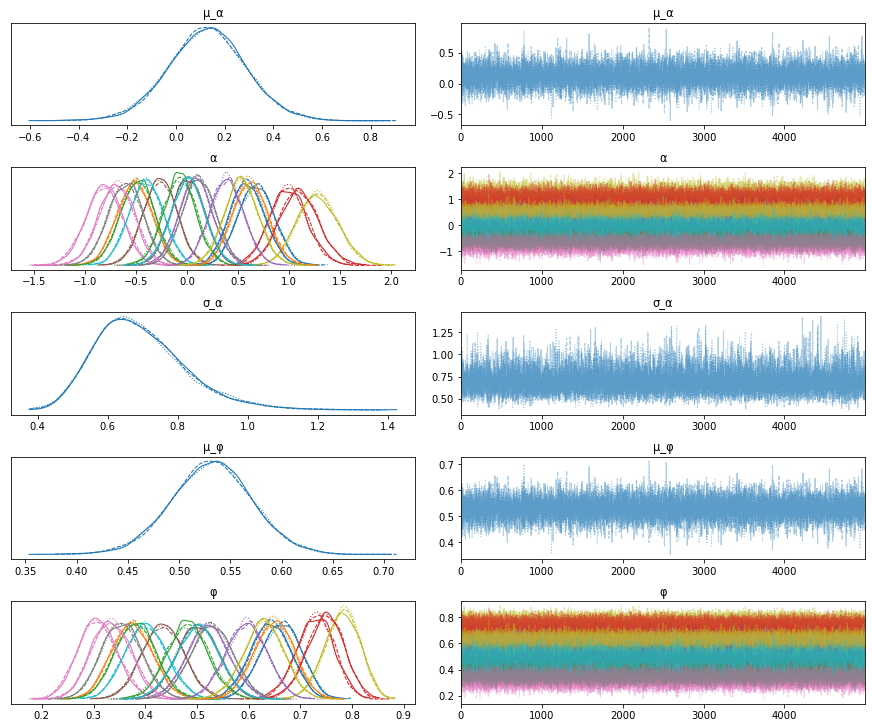

In [8]:
# Save trace plot
pm.traceplot(trace);
fig = plt.gcf();
fig.savefig(timestamp+'_alc_trace.png')